In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import date
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib . pyplot as plt # library for plots
import matplotlib.animation as animation # lets animate the plots!
from matplotlib.pyplot import figure
import pickle

In [2]:
# setting saving directory
today = date.today()
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S") #do not put : or similar 
print (today)
print (now)

print("date and time =", dt_string)	    
root = "C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs"

#saving function
def saveAsCSV(df,name,rootdir = root):
    """
    df = dataframe
    name = name for saving in format: 'thisisthename.csv'
    rootdir = local saving directory, default is root
    """
    #now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
    savepath = rootdir +'/' + dt_string+'_'+ name 
    df.to_csv ( savepath, index = False, header=True)

#loading function
def loadCSV(name,rootdir = root):
    """
    rootdir = local saving directory, default is root
    name = exact name (including datetime and extention .csv)
    """
    #dt_string = now.strftime("%d-%m-%Y_%H-%M-%S") 
    loadpath = rootdir +'/'+name 
    print ("loading: ",loadpath)
    df = pd.read_csv(loadpath)
    return df
    

2020-06-24
2020-06-24 11:01:37.406656
date and time = 24-06-2020_11-01-37


In [45]:
os.getcwd()

'C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code'

In [238]:
os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\')

In [4]:
#here all the functions (for when we will use many df)

def splitWeek(df_test):
    condition = df_test['day_of_week'].isin(['Sunday','Saturday'])
    df_weekdays = df_test[~condition]
    df_weekend =  df_test[condition]
    return df_weekdays,df_weekend

def keep1(arrayorint):
    """
    array = array of numbers
    """
    if (type(arrayorint) != int):
        new_list =[] 
        for num in arrayorint:
            first_digit = int(str(num)[:1]) 
            new_list.append(first_digit)
        new = np.array(new_list)
    else: 
        new = int(str(arrayorint)[:1]) 
    return new

def keepOne(arrayorint):
    """
    array = array of numbers
    """
    if (type(arrayorint) != int):
        new_list =[] 
        for num in arrayorint:
            first_digit = int(np.floor(num / 1000))
            new_list.append(first_digit)
        new = np.array(new_list)
    else: 
        new = int(np.floor(arrayorint / 1000))
    return new


def infoDataFrame(dt_test):
    #how many entries in this dataset? 
    tot_rows= len(dt_test)
    print ("tot num entries in dataset: ",tot_rows)

    #how many hh in this dataset? 
    tot_hh  = len(dt_test.serial.unique())
    print ("tot num hh in dataset: ",tot_hh)

    #how many people in this dataset? 
    tot_ppl = len(dt_test.person_id.unique())
    print ("tot num people in dataset: ",tot_ppl )

    #how many rows in training and how many in testing? 
    train = np.floor(tot_rows*0.8)
    print ("train: %i,   test: %i" %(train,tot_rows-train))

def addUniquePersonID(dt_test):
    dt_test["person_id"] = dt_test["serial"] + dt_test["pnum"]/100
    return dt_test


def addNextActivity(df_test):
    whatisnext = []
    for i in range(len(df_test)):

        # Get details of row
        current_person_id = df_test['person_id'][i]
        current_activity = df_test['whatdoing_exact'][i]

        if i < (len(df_test)-1):
            #check next row
            next_person_id = df_test['person_id'][i+1]
            next_activity = df_test['whatdoing_exact'][i+1]

            # check and add
            if (current_person_id == next_person_id):
                whatisnext.append(next_activity)

            else: #assumption: we assume the activity is continued
                whatisnext.append(current_activity)

        else: #assumption: we assume the activity is continued
            #print (i)
            whatisnext.append(current_activity)

    whatisnext = pd.Series(whatisnext, name = 'Next_activity')
    new_column_df = whatisnext.to_frame()    

    #we check for missing values, if the new column is shorter--> erron in the concatenation!
    if (len(df_test) != len(whatisnext)):
        print("original len: %i, modified len: %i"  %(len(df_test) ,len(whatisnext)))

    #concat on axis = 1 --> we add one column
    df_test = pd.concat([df_test, new_column_df],axis=1)
    return df_test

def createTransitionMatrix (df_test):
    #get the indexes 
    all_indexes = df_test.index.values.tolist()
    
    #sizing 
    all_next_act= df_test['Next_activity']
    simplified_all_next_act = keepOne(all_next_act)
    unique_next_act =np.unique(simplified_all_next_act)
    #print (unique_next_act)
    n = len(unique_next_act)
    #print ("Number of unique Activities:",n)

    # Init
    total_tp = 144
    P_t = np.zeros([total_tp, n, n]) # <- 3D array for 144 * transition matrices

    # For debugging
    test = False

    # Loop through all activity entries again
    for i in all_indexes:
        #here we get double codes
        t = df_test['time_period'][i] # <- % 144 to take all days in the years
        j = df_test['whatdoing_exact'][i] # <- current state
        k = df_test['Next_activity'][i]  # <- next state
        #print (t,j,k)
        
        #here we simplify them into one (eg "31" ->"3", "32"->"3", "99"->9)
        j_simply = keepOne(j.item())
        k_simply = keepOne(k.item())
        #print (type(t),type(j_simply),type(k_simply))

        #we take their positional indexes from unique_next_act
        j_index= np.where(unique_next_act == j_simply) 
        k_index= np.where(unique_next_act == k_simply) 

        #to increase the right bin
        P_t[t, j_index, k_index] += 1 # <- add one to probability, we'll divide later
        
        #if test:
            #print(activ_array[i, :])
            #print("At time %0.0f, the person is transitioning from %0.0f to %0.0f" % (t, j, k))
            #print("------")
            
    for t in range(total_tp):
        P_t[t] = (P_t[t].T/np.sum(P_t[t], axis=1)).T # <- transpose and transpose back to match axes with division operator
        for row in range(n):
            if np.isnan(P_t[t, row]).any(): # <- replace nans with 0s
                P_t[t, row] = np.zeros(n)
       
    return P_t
    

In [5]:
# Load data
#df_senior = loadCSV('20-06-2020_21-18-24_df_senior.csv')

df_child = loadCSV('23-06-2020_08-42-24_df_child.csv')
df_adult1 = loadCSV('23-06-2020_08-42-24_df_adult1.csv')
df_adult2 = loadCSV('23-06-2020_08-42-24_df_adult2.csv')
df_adult3 = loadCSV('23-06-2020_08-42-24_df_adult3.csv')
df_adult4 = loadCSV('23-06-2020_08-42-24_df_adult4.csv')
df_senior = loadCSV('23-06-2020_08-42-24_df_senior.csv')

loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_child.csv
loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_adult1.csv
loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_adult2.csv
loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_adult3.csv
loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_adult4.csv
loading:  C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/data/outputs/23-06-2020_08-42-24_df_senior.csv


In [6]:
#append them all in one vector
all_dataframes = []
all_dataframes.append(df_child)
all_dataframes.append(df_adult1)
all_dataframes.append(df_adult2)
all_dataframes.append(df_adult3)
all_dataframes.append(df_adult4)
all_dataframes.append(df_senior)

In [7]:
#append all dataframes_labels in one vector
all_dataframes_labels = []
all_dataframes_labels.append('df_child')
all_dataframes_labels.append('df_adult1')
all_dataframes_labels.append('df_adult2')
all_dataframes_labels.append('df_adult3')
all_dataframes_labels.append('df_adult4')
all_dataframes_labels.append('df_senior')

In [8]:
for i in range(len(all_dataframes)):
    print ("shape of %s : %s"%(all_dataframes_labels[i], all_dataframes[i].shape))

shape of df_child : (352312, 15)
shape of df_adult1 : (250219, 15)
shape of df_adult2 : (461555, 15)
shape of df_adult3 : (525569, 15)
shape of df_adult4 : (435037, 15)
shape of df_senior : (185246, 15)


In [9]:
#peek in columns and setting a new order
df_senior.head()
cols = list(df_senior)
#print (cols)

newcols = ['old_time_index',
 'person_id',
 'serial',
 'pnum',
 'Date',
 'Season',
 'day_of_week',
 'New_Time',
 'time_period',
 'whatdoing_exact',
 'sex',
 'age',
 'Time',
 't_start',
 'eptime']

In [10]:
# sort df 
def sortColumns(df_test, newcols):
    df_test = df_test.ix[:,newcols]
    return df_test
    

df_child = df_child.ix[:,newcols]
df_adult1 = df_adult1.ix[:,newcols]
df_adult2 = df_adult2.ix[:,newcols]
df_adult3 = df_adult3.ix[:,newcols]
df_adult4 = df_adult4.ix[:,newcols]
df_senior = df_senior.ix[:,newcols]

df_senior.head()

C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
C

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,Time,t_start,eptime
0,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:00:00,18,110,1.0,75.0,03:00:00,2014-12-07 03:00:00,10.0
1,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:10:00,19,110,1.0,75.0,03:00:00,2014-12-07 03:00:00,10.0
2,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:20:00,20,110,1.0,75.0,03:00:00,2014-12-07 03:00:00,10.0
3,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:30:00,21,110,1.0,75.0,03:00:00,2014-12-07 03:00:00,10.0
4,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:40:00,22,110,1.0,75.0,03:00:00,2014-12-07 03:00:00,10.0


In [11]:
# drop columns that are not useful
#df_senior = df_senior.drop(columns=['Time','eptime'])

df_child = df_child.drop(columns=['Time','eptime'])
df_adult1 = df_adult1.drop(columns=['Time','eptime'])
df_adult2 = df_adult2.drop(columns=['Time','eptime'])
df_adult3 = df_adult3.drop(columns=['Time','eptime'])
df_adult4 = df_adult4.drop(columns=['Time','eptime'])
df_senior = df_senior.drop(columns=['Time','eptime'])

df_senior.head()

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start
0,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:00:00,18,110,1.0,75.0,2014-12-07 03:00:00
1,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:10:00,19,110,1.0,75.0,2014-12-07 03:00:00
2,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:20:00,20,110,1.0,75.0,2014-12-07 03:00:00
3,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:30:00,21,110,1.0,75.0,2014-12-07 03:00:00
4,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:40:00,22,110,1.0,75.0,2014-12-07 03:00:00


### dataframe overview

In [12]:
for i in range(len(all_dataframes)):
    df_test = all_dataframes[i]
    print ("")
    print ("Check on %s"%(all_dataframes_labels[i]))
    infoDataFrame(df_test)


Check on df_child
tot num entries in dataset:  352312
tot num hh in dataset:  807
tot num people in dataset:  1230
train: 281849,   test: 70463

Check on df_adult1
tot num entries in dataset:  250219
tot num hh in dataset:  661
tot num people in dataset:  874
train: 200175,   test: 50044

Check on df_adult2
tot num entries in dataset:  461555
tot num hh in dataset:  1193
tot num people in dataset:  1609
train: 369244,   test: 92311

Check on df_adult3
tot num entries in dataset:  525569
tot num hh in dataset:  1353
tot num people in dataset:  1830
train: 420455,   test: 105114

Check on df_adult4
tot num entries in dataset:  435037
tot num hh in dataset:  1136
tot num people in dataset:  1516
train: 348029,   test: 87008

Check on df_senior
tot num entries in dataset:  185246
tot num hh in dataset:  539
tot num people in dataset:  645
train: 148196,   test: 37050


In [13]:
#BEFORE splitting the dataset in training and test we should create a column with NEXTwhatisdoing 
#for each household, for each person
#giving that the lines are ordered in theory checking the pnum would be enough, but anyway we have the person_id!
#df_senior = addNextActivity(df_senior)

df_child = addNextActivity(df_child)
df_adult1 = addNextActivity(df_adult1)
df_adult2 = addNextActivity(df_adult2)
df_adult3 = addNextActivity(df_adult3)
df_adult4 = addNextActivity(df_adult4)
df_senior = addNextActivity(df_senior)


In [14]:
#append them all in one vector
all_dataframes = []
all_dataframes.append(df_child)
all_dataframes.append(df_adult1)
all_dataframes.append(df_adult2)
all_dataframes.append(df_adult3)
all_dataframes.append(df_adult4)
all_dataframes.append(df_senior)

In [15]:
df_adult3.head()

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start,Next_activity
0,0,11011202.01,11011202,1,2014-12-11,winter,Thursday,03:00:00,18,110,2.0,48.0,2014-12-11 03:00:00,110
1,0,11011202.01,11011202,1,2014-12-11,winter,Thursday,03:10:00,19,110,2.0,48.0,2014-12-11 03:00:00,110
2,0,11011202.01,11011202,1,2014-12-11,winter,Thursday,03:20:00,20,110,2.0,48.0,2014-12-11 03:00:00,110
3,0,11011202.01,11011202,1,2014-12-11,winter,Thursday,03:30:00,21,110,2.0,48.0,2014-12-11 03:00:00,110
4,0,11011202.01,11011202,1,2014-12-11,winter,Thursday,03:40:00,22,110,2.0,48.0,2014-12-11 03:00:00,110


In [252]:
#save matrix 
saveAsCSV(df_child,'df_child_withnextactivity')
saveAsCSV(df_adult1,'df_adult1_withnextactivity')
saveAsCSV(df_adult2,'df_adult2_withnextactivity')
saveAsCSV(df_adult3,'df_adult3_withnextactivity')
saveAsCSV(df_adult4,'df_adult4_withnextactivity')
saveAsCSV(df_senior,'df_senior_withnextactivity')

In [16]:
df_senior.head()

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start,Next_activity
0,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:00:00,18,110,1.0,75.0,2014-12-07 03:00:00,110
1,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:10:00,19,110,1.0,75.0,2014-12-07 03:00:00,110
2,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:20:00,20,110,1.0,75.0,2014-12-07 03:00:00,110
3,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:30:00,21,110,1.0,75.0,2014-12-07 03:00:00,110
4,142,11011203.01,11011203,1,2014-12-07,winter,Sunday,03:40:00,22,110,1.0,75.0,2014-12-07 03:00:00,110


## Useful time converters

In [17]:
time_converter = df_senior[['New_Time','time_period']].head(144)
time_converter_df = time_converter.sort_values(by='time_period',ascending=True)
time_converter_df
saveAsCSV(time_converter_df,'time_converter_df.csv')


In [18]:
hours_of_day = time_converter_df['New_Time'].tolist()
hours_of_day[18] #this is 3am
T1 = (hours_of_day[18:144])
T2 = (hours_of_day [0:18])

T_master = T1+T2
#T_master
#print(type(T[0]))
#counter = 0
#for t in T:
    #print(counter, t)
    #counter +=1

In [20]:
random_person= (df_child.sample()['person_id']).tolist()[0]
#print (type(random_person[0]))
random_person
onechild = df_child.loc[df_child['person_id'] == random_person]
onechild.head()

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start,Next_activity
100799,162619,13280707.03,13280707,3,2014-08-02,summer,Saturday,02:00:00,12,110,1.0,18.0,2014-08-02 02:00:00,110
100800,162620,13280707.03,13280707,3,2014-08-02,summer,Saturday,02:10:00,13,110,1.0,18.0,2014-08-02 02:10:00,110
100801,162620,13280707.03,13280707,3,2014-08-02,summer,Saturday,02:20:00,14,110,1.0,18.0,2014-08-02 02:10:00,110
100802,162620,13280707.03,13280707,3,2014-08-02,summer,Saturday,02:30:00,15,110,1.0,18.0,2014-08-02 02:10:00,110
100803,162620,13280707.03,13280707,3,2014-08-02,summer,Saturday,02:40:00,16,110,1.0,18.0,2014-08-02 02:10:00,110


## Plotting 

In [42]:
# lets have a look at a typical week day and weekend day

def peekAndPlot(i,dayAsString):
    
    df_test = all_dataframes [i]
    name_df = all_dataframes_labels [i]
    df_test = df_test.loc[df_test['day_of_week'] == dayAsString]
    print (df_test.head())
    random_line = df_test.sample()
    random_ID = random_line['person_id'].tolist()[0]
    
    oneperson = df_test.loc[df_test['person_id'] == random_ID]
    oneperson = oneperson .loc[oneperson ['day_of_week'] == dayAsString]
    oneperson_oneday = oneperson.head(144)

    activityList = oneperson_oneday['whatdoing_exact']
    #activityList
    oneperson_oneday["Current_Activity_short"] = oneperson_oneday["whatdoing_exact"].apply(keepOne)
    activityList = oneperson_oneday['Current_Activity_short']
    T = oneperson_oneday['New_Time'].tolist()
    print (len(activityList))
    #onechild_oneday[['New_Time','whatdoing_exact','Current_Activity_short']]

    fig = plt.figure(figsize=(40, 5))
    label = dayAsString+','+name_df+','+str(random_ID) +' - Real'
    fig.suptitle(label)
    
    plt.plot(T, activityList)
    plt.xticks(rotation=45)
    #plt.xticks(np.arange(min(T), max(T), 6))
    #ax.set_xticks(ax.get_xticks()[::6])
    plt.yticks(np.arange(0, 10, 1))
    plt.grid(axis='activityList', linestyle='-')
    
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
    plt.savefig(dt_string+label+'.png')
    
    return random_ID,activityList
#[['New_Time','whatdoing_exact']]

def peek(i,dayAsString):
    
    df_test = all_dataframes [i]
    name_df = all_dataframes_labels [i]
    df_test = df_test.loc[df_test['day_of_week'] == dayAsString]
    #print (df_test.head())
    random_line = df_test.sample()
    random_ID = random_line['person_id'].tolist()[0]
    
    oneperson = df_test.loc[df_test['person_id'] == random_ID]
    oneperson = oneperson .loc[oneperson ['day_of_week'] == dayAsString]
    oneperson_oneday = oneperson.head(144)

    activityList = oneperson_oneday['whatdoing_exact']
    #activityList
    oneperson_oneday["Current_Activity_short"] = oneperson_oneday["whatdoing_exact"].apply(keepOne)
    activityList = oneperson_oneday['Current_Activity_short']
    
    return random_ID,activityList,oneperson_oneday

def peekSeason(df_test,name_df,seasonAsString):
    """
    there seem not to be less input in summer? to investigate...
    
    """
    #df_test = all_dataframes [i]
    #name_df = all_dataframes_labels [i]
    df_test = df_test.loc[df_test['Season'] == seasonAsString]
    #print (df_test.head())
    if (len(df_test)!= 0):
        random_line = df_test.sample()

        random_ID = random_line['person_id'].tolist()[0]

        oneperson = df_test.loc[df_test['person_id'] == random_ID]
        oneperson = oneperson .loc[oneperson ['Season'] == seasonAsString]
        oneperson_oneday = oneperson.head(144)

        activityList = oneperson_oneday['whatdoing_exact']
        #activityList
        oneperson_oneday["Current_Activity_short"] = oneperson_oneday["whatdoing_exact"].apply(keepOne)
        activityList = oneperson_oneday['Current_Activity_short']
    else:
        print ("no data for %s in %s"%(name_df,seasonAsString))
        random_ID= 42
        activityList = [0] * 144
        oneperson_oneday = []
    return random_ID,activityList,oneperson_oneday


In [33]:
all_dataframes[0] # child

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start,Next_activity
0,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:00:00,18,110,1.0,13.0,2014-12-11 03:00:00,110
1,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:10:00,19,110,1.0,13.0,2014-12-11 03:00:00,110
2,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:20:00,20,110,1.0,13.0,2014-12-11 03:00:00,110
3,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:30:00,21,110,1.0,13.0,2014-12-11 03:00:00,110
4,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:40:00,22,110,1.0,13.0,2014-12-11 03:00:00,110
5,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,03:50:00,23,110,1.0,13.0,2014-12-11 03:00:00,110
6,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,04:00:00,24,110,1.0,13.0,2014-12-11 03:00:00,110
7,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,04:10:00,25,110,1.0,13.0,2014-12-11 03:00:00,110
8,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,04:20:00,26,110,1.0,13.0,2014-12-11 03:00:00,110
9,88,11011202.04,11011202,4,2014-12-11,winter,Thursday,04:30:00,27,110,1.0,13.0,2014-12-11 03:00:00,110


   old_time_index    person_id    serial  pnum        Date  Season  \
0             142  11011203.01  11011203     1  2014-12-07  winter   
1             142  11011203.01  11011203     1  2014-12-07  winter   
2             142  11011203.01  11011203     1  2014-12-07  winter   
3             142  11011203.01  11011203     1  2014-12-07  winter   
4             142  11011203.01  11011203     1  2014-12-07  winter   

  day_of_week  New_Time  time_period  whatdoing_exact  sex   age  \
0      Sunday  03:00:00           18              110  1.0  75.0   
1      Sunday  03:10:00           19              110  1.0  75.0   
2      Sunday  03:20:00           20              110  1.0  75.0   
3      Sunday  03:30:00           21              110  1.0  75.0   
4      Sunday  03:40:00           22              110  1.0  75.0   

               t_start  Next_activity  
0  2014-12-07 03:00:00            110  
1  2014-12-07 03:00:00            110  
2  2014-12-07 03:00:00            110  
3  2014-12

C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


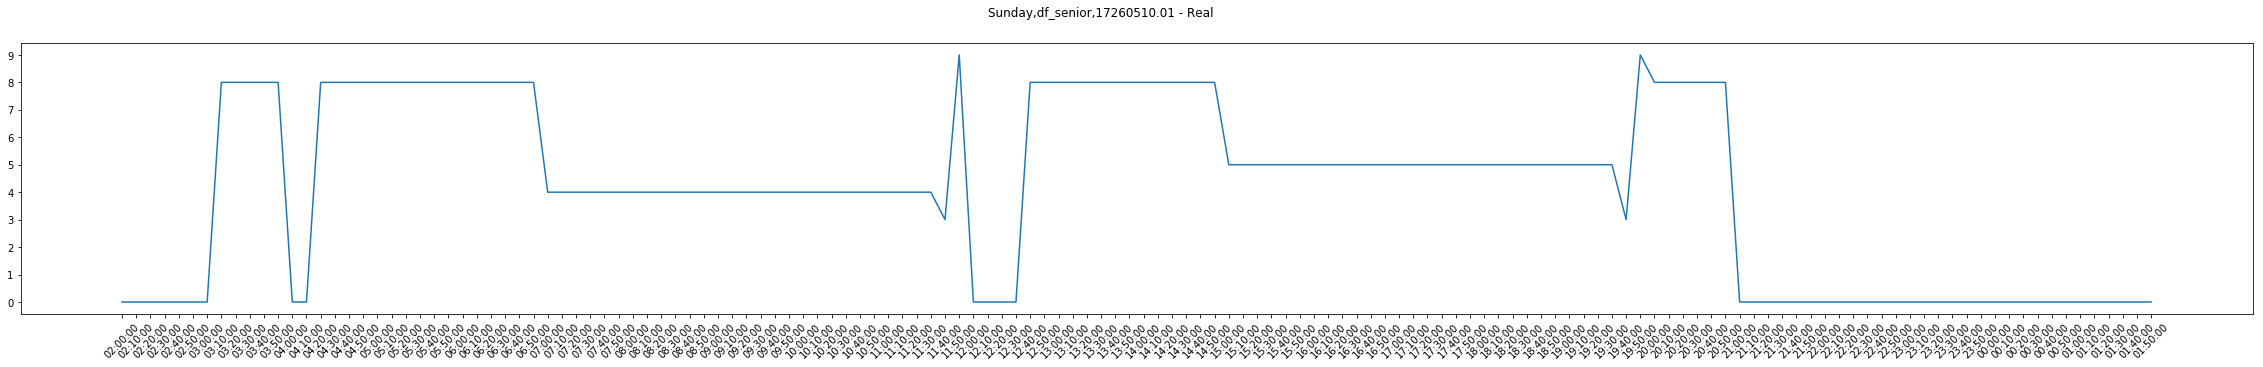

In [22]:
# one at the time
random_ID,activityList = peekAndPlot(5,'Sunday')

In [259]:
os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\figures\\')

#### Plot weekday/weekend

C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


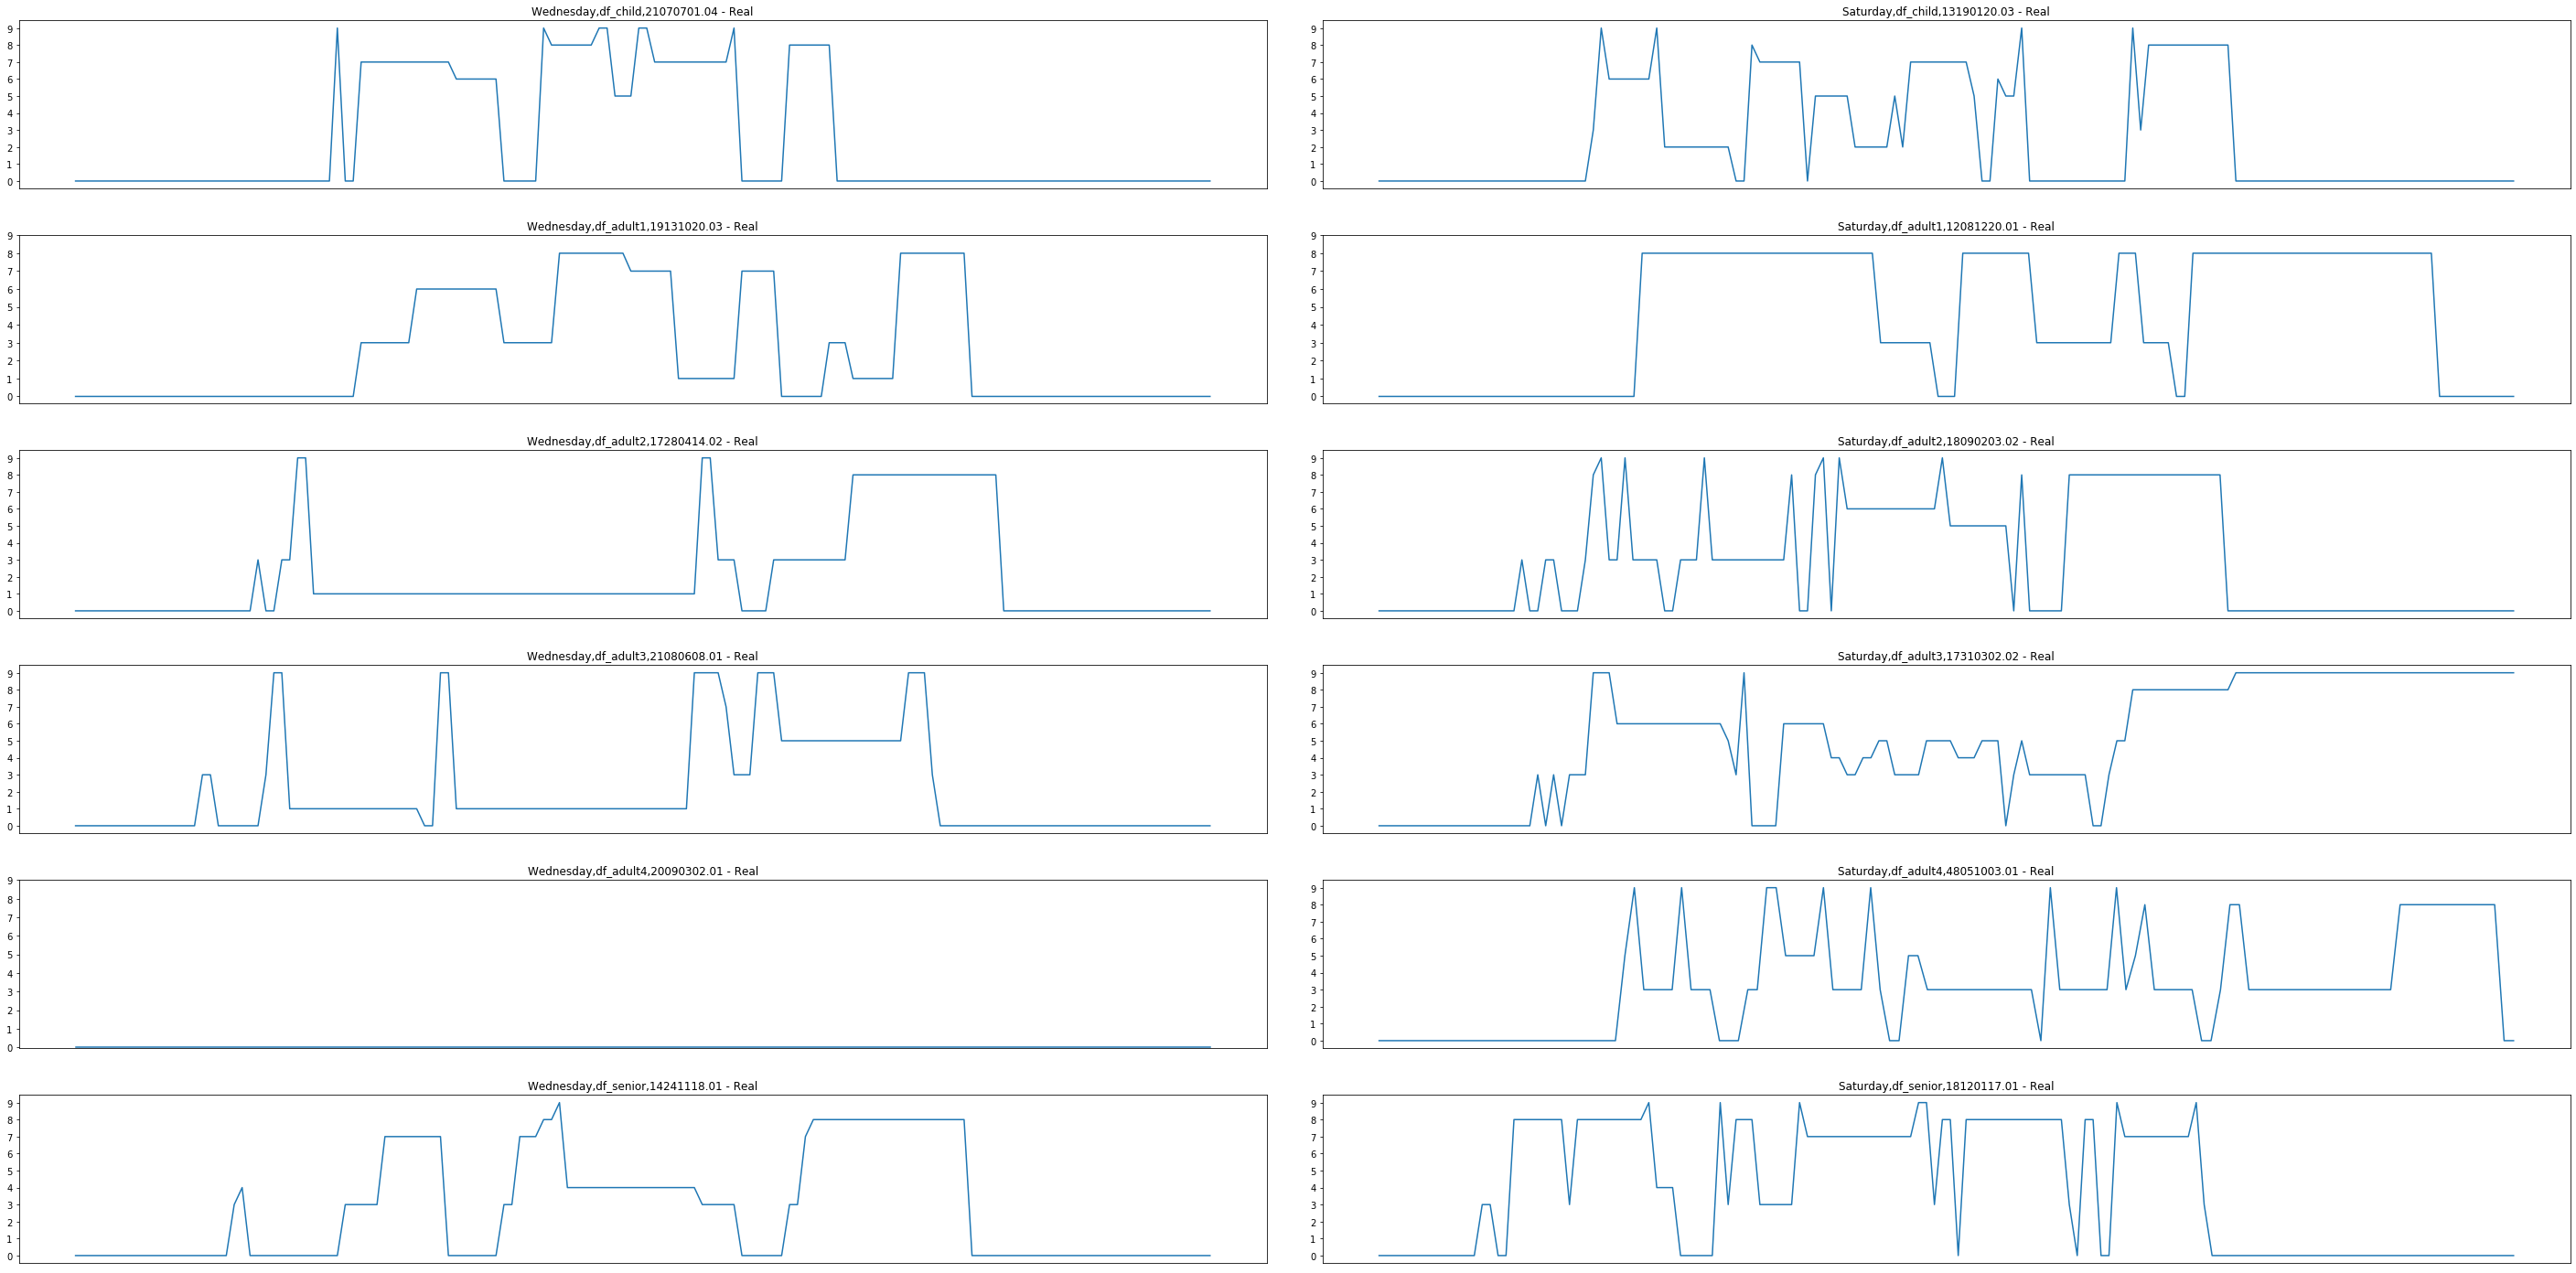

In [23]:
# multiple random plots BY WEEKDAY 
#os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\figures\\')
#root = "C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/plots_images_graphs"


# plt.subplots(number of lines, number of columns,figsize=(30,15))
fig, axs = plt.subplots(len(all_dataframes), 2,figsize=(40,20))
fig.tight_layout(pad=3.0)
fig.suptitle("")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plot_column_counter = 0
for i in range(len(all_dataframes)):
    plot_row_counter = 0
    
    df_test = all_dataframes [i]
    name_df = all_dataframes_labels [i]
    
    days = ['Wednesday','Saturday']

    container_alist = []
    all_IDs = []
    for day in days:
        random_ID,activityList,oneperson_oneday= peek(i,day)
        all_IDs.append(random_ID)
        container_alist.append(activityList)
        if (random_ID == 42):
            T = T_master
        else:
            T = oneperson_oneday['New_Time'].tolist()

        
        label = day+','+name_df+','+str(random_ID) +' - Real'
        ax = axs[plot_column_counter,plot_row_counter]
        ax.axes.xaxis.set_visible(False)
        ax.title.set_text(label)
        ax.plot(T, activityList)
        #ax.set_xticklabels(T,rotation=45)
        ax.set_yticks(np.arange(0, 10, 1))
        ax.grid(axis='activityList', linestyle='-')

        
        
        plot_row_counter  = 1
    plot_column_counter +=1 

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
plt.savefig(dt_string+'_all_df'+'.png')
    

##### Plot by season

winter

spring


C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



summer

autumn

winter

spring

summer

autumn

winter

spring

summer

autumn

winter

spring

summer

autumn

winter

spring

summer

autumn

winter

spring

summer

autumn



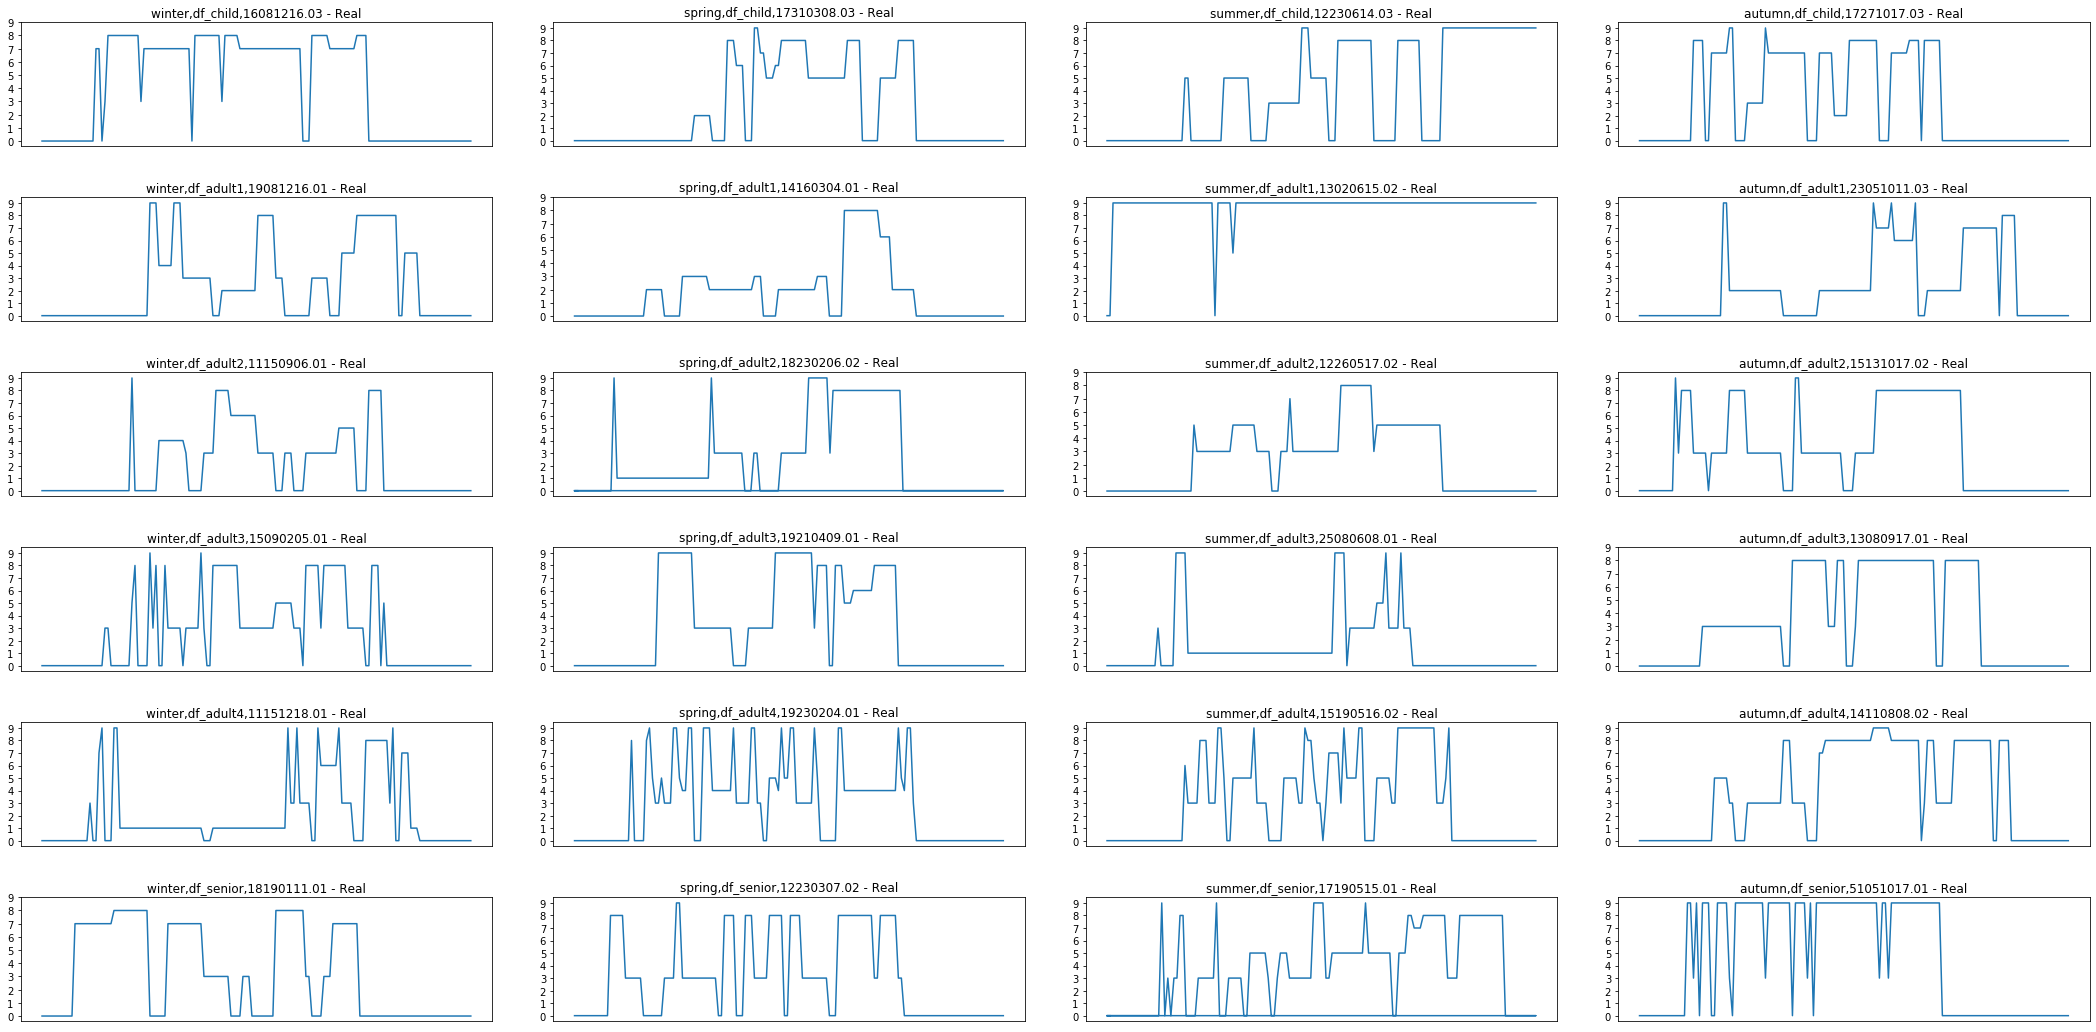

In [44]:
# multiple random plots by season 
#os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\figures\\')
#root = "C:/Users/arita/Documents/private/Data Engineering/2semestre/Stochastic_modeling/Project/plots_images_graphs"


# plt.subplots(number of lines, number of columns,figsize=(30,15))
fig, axs = plt.subplots(len(all_dataframes), 4,figsize=(30,15))
fig.tight_layout(pad=3.0)
fig.suptitle("")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plot_column_counter = 0
for i in range(len(all_dataframes)):
    plot_row_counter = 0
    
    df_test = all_dataframes [i]
    name_df = all_dataframes_labels [i]
    
    seasons = ['winter', 'spring','summer','autumn'] #found the problem, i had mispelled summer
    
    
    container_alist = []
    all_IDs = []
    for season in seasons:
        print (season)
        random_ID,activityList,oneperson_oneday= peekSeason(df_test,name_df,season)
        all_IDs.append(random_ID)
        container_alist.append(activityList)
        
        if (random_ID == 42):
            T = T_master
        else:
            T = oneperson_oneday['New_Time'].tolist()
        #print (len(activityList))
        
        label = season+','+name_df+','+str(random_ID) +' - Real'
        ax = axs[plot_column_counter,plot_row_counter]
        ax.axes.xaxis.set_visible(False)
        ax.title.set_text(label)
        ax.plot(T, activityList)
        #ax.set_xticklabels(T,rotation=45)
        ax.set_yticks(np.arange(0, 10, 1))
        #ax.grid(axis='activityList', linestyle='-')
        
        print("")
        
        plot_row_counter  += 1
    plot_column_counter +=1 

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
plt.savefig(dt_string+'_all_df_by_season'+'.png')

### summer data seems to be frequently missing

since the data cannot really be split per season... we split in week day and weekend

In [38]:
for i in range(len(all_dataframes)):
    df_test = all_dataframes [i]
    name_df = all_dataframes_labels [i]
    
    print (name_df)
    
    #check on winter
    people = df_test.loc[df_test['Season'] == 'winter']
    print('winter:',len(people.person_id.unique()))

    #check on spring
    people = df_test.loc[df_test['Season'] == 'spring']
    print('spring:',len(people.person_id.unique()))

    #check on summer
    people = df_test.loc[df_test['Season'] == 'summer']
    print('summer:',len(people.person_id.unique()))

    #check on autumn
    people = df_test.loc[df_test['Season'] == 'autumn']
    print('autumn:',len(people.person_id.unique()))
          
    print ("")

df_child
winter: 257
spring: 310
summer: 306
autumn: 387

df_adult1
winter: 223
spring: 218
summer: 188
autumn: 274

df_adult2
winter: 405
spring: 385
summer: 376
autumn: 491

df_adult3
winter: 415
spring: 457
summer: 458
autumn: 566

df_adult4
winter: 351
spring: 381
summer: 404
autumn: 419

df_senior
winter: 153
spring: 155
summer: 163
autumn: 195



#### split the df in weekday and weekends

In [177]:
df_test = df_child.head(1000)
df_weekdays,df_weekend = splitWeek(df_test)

### split by weekday, split in train and test, save in csv, calculate P_t and save;  all at once cause its easier

In [210]:
os.getcwd()
print ("Now in --->%s "%(os.getcwd()))

Now in --->C:\Users\arita\Documents\GitHub\02443-SimSolarEnergy\code\tm 


In [229]:
# re-create labels

P_t_labels = []
splitDF_labels = []
for i in range(len(all_dataframes)):
    df = all_dataframes[i]
    df_label = all_dataframes_labels[i]
    new_labels = ['train'+df_label+'_weekdays','test'+df_label+'_weekdays','train'+df_label+'_weekend','test'+df_label+'_weekend']
    splitDF_labels = splitDF_labels + new_labels
    for n in range(4):
        name = dt_string+'_'+'P_t_'+new_labels[n]+'.pkl'
        P_t_labels.append(name)

print(splitDF_labels)
print(P_t_labels)

#change save directory 
os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\labels')


with open( 'splitDF_labels.pkl','wb') as f:
    pickle.dump(splitDF_labels, f)
    
with open( 'P_t_labels.pkl','wb') as f:
    pickle.dump(P_t_labels, f)

['traindf_child_weekdays', 'testdf_child_weekdays', 'traindf_child_weekend', 'testdf_child_weekend', 'traindf_adult1_weekdays', 'testdf_adult1_weekdays', 'traindf_adult1_weekend', 'testdf_adult1_weekend', 'traindf_adult2_weekdays', 'testdf_adult2_weekdays', 'traindf_adult2_weekend', 'testdf_adult2_weekend', 'traindf_adult3_weekdays', 'testdf_adult3_weekdays', 'traindf_adult3_weekend', 'testdf_adult3_weekend', 'traindf_adult4_weekdays', 'testdf_adult4_weekdays', 'traindf_adult4_weekend', 'testdf_adult4_weekend', 'traindf_senior_weekdays', 'testdf_senior_weekdays', 'traindf_senior_weekend', 'testdf_senior_weekend']
['22-06-2020_21-30-03_P_t_traindf_child_weekdays.pkl', '22-06-2020_21-30-03_P_t_testdf_child_weekdays.pkl', '22-06-2020_21-30-03_P_t_traindf_child_weekend.pkl', '22-06-2020_21-30-03_P_t_testdf_child_weekend.pkl', '22-06-2020_21-30-03_P_t_traindf_adult1_weekdays.pkl', '22-06-2020_21-30-03_P_t_testdf_adult1_weekdays.pkl', '22-06-2020_21-30-03_P_t_traindf_adult1_weekend.pkl', '22

In [261]:
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

for i in range(len(all_dataframes)):
    df = all_dataframes[i]
    df_label = all_dataframes_labels[i]
    new_labels = ['train'+df_label+'_weekdays','test'+df_label+'_weekdays','train'+df_label+'_weekend','test'+df_label+'_weekend']
    df_weekdays,df_weekend = splitWeek(df)
    
    #change save directory 
    os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\figures')
    
    #weekdays dframes split
    print ("splitting on %s"%(df_label+'_weekdays'))
    train_df_weekdays, test_df_weekdays= train_test_split(df_weekdays)
    saveAsCSV(train_df_weekdays,new_labels[0]+'.csv')
    saveAsCSV(test_df_weekdays,new_labels[1]+'.csv')
    
    print ("splitting %s"%(df_label+'_weekend'))
    #weekends dframes split
    train_df_weekend, test_df_weekend = train_test_split(df_weekend)
    saveAsCSV(train_df_weekend,new_labels[2]+'.csv')
    saveAsCSV(test_df_weekend,new_labels[3]+'.csv')
    
    # at this point we have four df
    alltraintest_df = []
    alltraintest_df.append(train_df_weekdays)
    alltraintest_df.append(test_df_weekdays)
    alltraintest_df.append(train_df_weekend)
    alltraintest_df.append(test_df_weekend)
    
    print("%s split in %i df"%(df_label,len(alltraintest_df )))
    
    #change save directory 
    os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\tm')
    print ("In %s "%(os.getcwd()))
    
    # for each one we create and save the relative transition matrix
    
    for n in range(len(alltraintest_df)):
        single_df = alltraintest_df[n]
        name = dt_string+'_'+'P_t_'+new_labels[n]+'.pkl'
        #print (single_df.head(10))
        P_t = createTransitionMatrix(single_df)
        
        print("saved transition matrix %s"%(name))
        with open( name,'wb') as f:
            pickle.dump(P_t, f)



splitting on df_child_weekdays
splitting df_child_weekend
df_child split in 4 df
In C:\Users\arita\Documents\GitHub\02443-SimSolarEnergy\code\tm 


C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide


saved transition matrix 23-06-2020_09-18-48_P_t_traindf_child_weekdays.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_testdf_child_weekdays.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_traindf_child_weekend.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_testdf_child_weekend.pkl
splitting on df_adult1_weekdays
splitting df_adult1_weekend
df_adult1 split in 4 df
In C:\Users\arita\Documents\GitHub\02443-SimSolarEnergy\code\tm 
saved transition matrix 23-06-2020_09-18-48_P_t_traindf_adult1_weekdays.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_testdf_adult1_weekdays.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_traindf_adult1_weekend.pkl
saved transition matrix 23-06-2020_09-18-48_P_t_testdf_adult1_weekend.pkl
splitting on df_adult2_weekdays
splitting df_adult2_weekend
df_adult2 split in 4 df
In C:\Users\arita\Documents\GitHub\02443-SimSolarEnergy\code\tm 
saved transition matrix 23-06-2020_09-18-48_P_t_traindf_adult2_weekdays.pkl
saved transition matrix 23-06-

# old code

In [207]:
os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\tm')

In [262]:
#from sklearn.model_selection import train_test_split

# split datasets in train and test
testSize = 0.2
train_df_child, test_df_child = train_test_split(df_child, test_size=testSize)
train_df_adult1, test_df_adult1 = train_test_split(df_adult1, test_size=testSize)
train_df_adult2, test_df_adult2 = train_test_split(df_adult2, test_size=testSize)
train_df_adult3, test_df_adult3 = train_test_split(df_adult3, test_size=testSize)
train_df_adult4, test_df_adult4 = train_test_split(df_adult4, test_size=testSize)
train_df_senior, test_df_senior = train_test_split(df_senior, test_size=testSize)



In [263]:
#save them 
saveAsCSV(train_df_child,'train_df_child.csv')
saveAsCSV(test_df_child,'test_df_child.csv')

saveAsCSV(train_df_adult1,'train_df_adult1.csv')
saveAsCSV(test_df_adult1,'test_df_adult1.csv')

saveAsCSV(train_df_adult2,'train_df_adult2.csv')
saveAsCSV(test_df_adult2,'test_df_adult2.csv')

saveAsCSV(train_df_adult3,'train_df_adult3.csv')
saveAsCSV(test_df_adult3,'test_df_adult3.csv')

saveAsCSV(train_df_adult4,'train_df_adult4.csv')
saveAsCSV(test_df_adult4,'test_df_adult4.csv')

saveAsCSV(train_df_senior,'train_df_senior.csv')
saveAsCSV(test_df_senior,'test_df_senior.csv')

In [268]:
len(train_df_senior)
train_df_senior.head(25)
#perfect!

,old_time_index,person_id,serial,pnum,Date,Season,day_of_week,New_Time,time_period,whatdoing_exact,sex,age,t_start,Next_activity
89518,278221,16040807.01,16040807,1,2014-08-16,summer,Saturday,22:30:00,135,110,2.0,85.0,2014-08-16 21:10:00,110
46205,139979,13150910.01,13150910,1,2014-10-04,autumn,Saturday,23:50:00,143,110,1.0,79.0,2014-10-04 20:40:00,110
41615,125729,13040812.02,13040812,2,2014-09-22,autumn,Monday,20:00:00,120,4320,2.0,76.0,2014-09-22 20:00:00,4320
50642,167401,14011213.01,14011213,1,2015-02-08,winter,Sunday,01:00:00,6,110,1.0,76.0,2015-02-08 21:50:00,110
166756,522702,20310314.01,20310314,1,2014-04-27,spring,Sunday,14:30:00,87,5310,2.0,93.0,2014-04-27 14:10:00,5310
165476,510950,20171111.01,20171111,1,2014-12-03,winter,Wednesday,18:10:00,109,8210,2.0,86.0,2014-12-03 18:00:00,8210
125531,397093,18050509.01,18050509,1,2014-06-07,summer,Saturday,18:00:00,108,3330,2.0,81.0,2014-06-07 18:00:00,3330
75837,235585,15110818.02,15110818,2,2014-08-17,summer,Sunday,18:50:00,113,8210,1.0,82.0,2014-08-17 17:00:00,8210
97327,322953,16280708.01,16280708,1,2014-08-07,summer,Thursday,08:10:00,49,9360,1.0,85.0,2014-08-07 08:10:00,3610
40004,121010,13011204.02,13011204,2,2014-12-11,winter,Thursday,16:30:00,99,7310,2.0,75.0,2014-12-11 16:00:00,7310


In [307]:
#all_indexes = df_test.index.values.tolist()
#print (np.unique (all_indexes))
#train_df_adult1['time_period'][0]

112

In [264]:
#create the transition matrix for each train df

P_t_child = createTransitionMatrix(train_df_child)
P_t_adult1 = createTransitionMatrix(train_df_adult1)
P_t_adult2 = createTransitionMatrix(train_df_adult2)
P_t_adult3 = createTransitionMatrix(train_df_adult3)
P_t_adult4 = createTransitionMatrix(train_df_adult4)
P_t_senior = createTransitionMatrix(train_df_senior)

C:\Users\arita\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in true_divide


In [350]:
# looks good!
print ((P_t_senior))

[[[1.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 1.         0.         0.        ]
  [0.2        0.         0.         ... 0.         0.8        0.        ]
  [0.         0.         0.         ... 0.         0.         1.        ]]

 [[0.99737533 0.         0.         ... 0.         0.00262467 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 1.         0.         0.        ]
  [0.         0.         0.         ... 0.         1.         0.        ]
  [0.         0.         0.         ... 0.         0.         1.        ]]

 [[1.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [265]:
import os
os.getcwd()
os.chdir('C:\\Users\\arita\\Documents\\GitHub\\02443-SimSolarEnergy\\code\\tm')

In [266]:
import pickle
#lets pickle the np array
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")

with open( dt_string+'_'+'P_t_child.pkl','wb') as f:
    pickle.dump(P_t_child, f)
    
with open( dt_string+'_'+'P_t_adult1.pkl','wb') as f:
    pickle.dump(P_t_adult1, f)

with open( dt_string+'_'+'P_t_adult2.pkl','wb') as f:
    pickle.dump(P_t_adult2, f)

with open( dt_string+'_'+'P_t_adult3.pkl','wb') as f:
    pickle.dump(P_t_adult3, f)

with open( dt_string+'_'+'P_t_adult4.pkl','wb') as f:
    pickle.dump(P_t_adult4, f)

with open( dt_string+'_'+'P_t_senior.pkl','wb') as f:
    pickle.dump(P_t_senior, f)
    

In [352]:
all_act = train_df_senior.whatdoing_exact
simplified_all_act = keepOne(all_act)
unique_act =np.unique(simplified_all_act)

In [353]:
unique_act

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])